In [9]:
pip uninstall -y torch torchvision torchaudio
pip install --index-url https://download.pytorch.org/whl/cpu \
  torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1


SyntaxError: invalid syntax (1938818664.py, line 1)

In [1]:
import os

dataset_path = r"C:\Users\richu\OneDrive\Desktop\tumor testing"  # change this to your dataset folder

for split in ['training', 'testing']:
    split_path = os.path.join(dataset_path, split)
    print(f"\n[{split.upper()} SET]")
    total = 0
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        count = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        print(f"{cls}: {count} images")
        total += count
    print(f"Total images in {split}: {total}")



[TRAINING SET]
NO TUMOR DETECTED: 1597 images
Total images in training: 1597

[TESTING SET]
GLIOMA TUMOR DETECTED: 300 images
MENINGIOMA TUMOR DETECTED: 306 images
NO TUMOR DETECTED: 405 images
PITUITARY TUMOR DETECTED: 300 images
Total images in testing: 1311


In [3]:
# ===== Autoencoder training on grayscale "no tumor" images =====
import os, time
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image
from torch.cuda.amp import autocast, GradScaler

# ---------- CONFIG ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

DATA_ROOT = r"C:\Users\richu\OneDrive\Desktop\tumor testing"  
TRAIN_DIR = os.path.join(DATA_ROOT, "training")                

IMG_SIZE = 224
BATCH    = 32         # drop to 16/8 if you hit OOM
EPOCHS   = 100
LR       = 1e-3
convert_mode = "L"    # <<<<<< GRAYSCALE

# ---------- TRANSFORMS (grayscale) ----------
tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=Image.BICUBIC),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),   # -> [-1, 1]
])

# ---------- DATA ----------
train_ds = datasets.ImageFolder(TRAIN_DIR, transform=tfms)
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=4, pin_memory=True)
print(f"Training samples: {len(train_ds)} | Classes: {train_ds.classes}")

# ---------- MODEL ----------
C = 1  # grayscale

class ConvAE(nn.Module):
    def __init__(self, c=C, latent=256):
        super().__init__()
        # Encoder: 224 -> 112 -> 56 -> 28 -> 14 -> 7
        self.enc = nn.Sequential(
            nn.Conv2d(c,   32, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(32,  64, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(64, 128, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(128,256, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(256,512, 3, 2, 1), nn.ReLU(True),
        )
        self.fc_mu  = nn.Linear(512*7*7, latent)
        self.fc_dec = nn.Linear(latent, 512*7*7)
        # Decoder: 7 -> 14 -> 28 -> 56 -> 112 -> 224
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(512,256,4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(256,128,4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(128,64, 4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(32,  C, 4,2,1),
            nn.Tanh(),  # outputs in [-1,1] to match normalization
        )

    def encode(self, x):
        h = self.enc(x).view(x.size(0), -1)
        return self.fc_mu(h)

    def decode(self, z):
        h = self.fc_dec(z).view(-1, 512, 7, 7)
        return self.dec(h)

    def forward(self, x):
        return self.decode(self.encode(x))

model  = ConvAE().to(device)
opt    = torch.optim.Adam(model.parameters(), lr=LR)
crit   = nn.MSELoss()                        # MSE
scaler = GradScaler(enabled=(device.type=="cuda"))

torch.backends.cudnn.benchmark = True
os.makedirs("checkpoints", exist_ok=True)

# ---------- TRAIN ----------
for ep in range(1, EPOCHS + 1):
    model.train()
    start = time.time()
    epoch_loss = 0.0

    for xb, _ in train_dl:
        xb = xb.to(device, non_blocking=True)
        opt.zero_grad(set_to_none=True)

        with autocast(enabled=(device.type=="cuda")):
            xh = model(xb)
            loss = crit(xh, xb)

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        epoch_loss += loss.item() * xb.size(0)

    avg = epoch_loss / len(train_dl.dataset)
    print(f"Epoch {ep:03d} | train_mse={avg:.6f} | time={time.time()-start:.1f}s")

# Save model
ckpt_path = "checkpoints/ae_final_mse_gpu_gray.pt"
torch.save(model.state_dict(), ckpt_path)
print(f"Model saved → {ckpt_path}")


Device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Training samples: 1597 | Classes: ['NO TUMOR DETECTED']
Epoch 001 | train_mse=0.174736 | time=11.7s
Epoch 002 | train_mse=0.138706 | time=11.6s
Epoch 003 | train_mse=0.120522 | time=11.6s
Epoch 004 | train_mse=0.106566 | time=11.5s
Epoch 005 | train_mse=0.099186 | time=11.6s
Epoch 006 | train_mse=0.094005 | time=11.6s
Epoch 007 | train_mse=0.087422 | time=12.0s
Epoch 008 | train_mse=0.081395 | time=11.6s
Epoch 009 | train_mse=0.075746 | time=11.8s
Epoch 010 | train_mse=0.070302 | time=11.6s
Epoch 011 | train_mse=0.065931 | time=11.6s
Epoch 012 | train_mse=0.062120 | time=11.8s
Epoch 013 | train_mse=0.058423 | time=11.8s
Epoch 014 | train_mse=0.053877 | time=11.6s
Epoch 015 | train_mse=0.050883 | time=11.6s
Epoch 016 | train_mse=0.047828 | time=11.5s
Epoch 017 | train_mse=0.045988 | time=11.7s
Epoch 018 | train_mse=0.043880 | time=11.6s
Epoch 019 | train_mse=0.041475 | time=11.6s
Epoch 020 | train_mse=0.039669 | time=11.6s
Epoch 021 |

AE loaded on: cuda
Classes: ['GLIOMA TUMOR DETECTED', 'MENINGIOMA TUMOR DETECTED', 'NO TUMOR DETECTED', 'PITUITARY TUMOR DETECTED'] | Images: 1311
Latent feature matrix: (1311, 256)

=== SVM (RBF) on latent space ===
Accuracy: 0.8401015228426396
Confusion matrix:
 [[ 78  10   1   1]
 [ 21  55  13   3]
 [  0  11 111   0]
 [  2   1   0  87]]
Report:
                            precision    recall  f1-score   support

    GLIOMA TUMOR DETECTED       0.77      0.87      0.82        90
MENINGIOMA TUMOR DETECTED       0.71      0.60      0.65        92
        NO TUMOR DETECTED       0.89      0.91      0.90       122
 PITUITARY TUMOR DETECTED       0.96      0.97      0.96        90

                 accuracy                           0.84       394
                macro avg       0.83      0.84      0.83       394
             weighted avg       0.84      0.84      0.84       394


=== RandomForest on latent space ===
Accuracy: 0.8045685279187818
Confusion matrix:
 [[ 74   9   0   7]
 [ 19

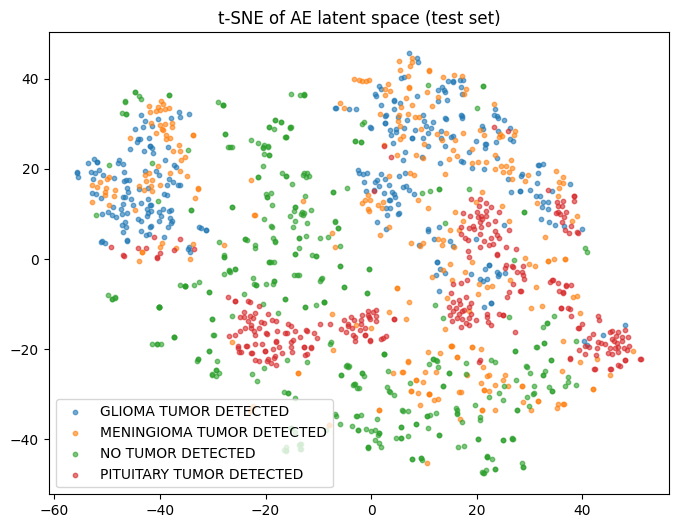

In [1]:
# ===== Latent-space classification from your trained grayscale AE =====
import os, numpy as np, torch, torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image

# ---- CONFIG ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_ROOT = r"C:\Users\richu\OneDrive\Desktop\tumor testing"   # change if needed
TEST_DIR  = os.path.join(DATA_ROOT, "test")
CKPT_PATH = "checkpoints/ae_final_mse_gpu_gray.pt"             # your AE checkpoint
IMG_SIZE  = 224
BATCH_FE  = 64   # feature-extraction batch size

# ---- Transforms (grayscale, must match training) ----
tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=Image.BICUBIC),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

# ---- Rebuild the same AE (C=1) and load weights ----
C = 1
class ConvAE(nn.Module):
    def __init__(self, c=C, latent=256):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(c,   32, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(32,  64, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(64, 128, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(128,256, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(256,512, 3, 2, 1), nn.ReLU(True),
        )
        self.fc_mu  = nn.Linear(512*7*7, 256)
        self.fc_dec = nn.Linear(256, 512*7*7)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(512,256,4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(256,128,4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(128,64, 4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(32,  C, 4,2,1),
            nn.Tanh(),
        )
    def encode(self,x): return self.fc_mu(self.enc(x).view(x.size(0),-1))
    def decode(self,z): return self.dec(self.fc_dec(z).view(-1,512,7,7))
    def forward(self,x): return self.decode(self.encode(x))

model = ConvAE().to(device)
model.load_state_dict(torch.load(CKPT_PATH, map_location=device))
model.eval()
print("AE loaded on:", device)

# ---- Build dataset from TEST_DIR and extract latent features ----
test_ds = datasets.ImageFolder(TEST_DIR, transform=tfms)
test_dl = DataLoader(test_ds, batch_size=BATCH_FE, shuffle=False, num_workers=2, pin_memory=True)
print("Classes:", test_ds.classes, "| Images:", len(test_ds))

features, labels = [], []
paths = [p for p,_ in test_ds.samples]

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device, non_blocking=True)
        z  = model.encode(xb)                 # (B, 256)
        features.append(z.detach().cpu().numpy())
        labels.extend([test_ds.classes[i] for i in yb.numpy()])

X = np.concatenate(features, axis=0)          # (N, 256)
y = np.array(labels)

print("Latent feature matrix:", X.shape)

# ---- Train/test split and classifiers on latent space ----
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# stratified split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

# A) SVM (RBF) — strong baseline on dense latent features
svm_clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", C=10, gamma="scale", class_weight="balanced"))
svm_clf.fit(X_tr, y_tr)
svm_pred = svm_clf.predict(X_te)
print("\n=== SVM (RBF) on latent space ===")
print("Accuracy:", accuracy_score(y_te, svm_pred))
print("Confusion matrix:\n", confusion_matrix(y_te, svm_pred, labels=test_ds.classes))
print("Report:\n", classification_report(y_te, svm_pred, target_names=test_ds.classes))

# B) RandomForest — quick, robust alternative (no scaling needed)
rf_clf = RandomForestClassifier(n_estimators=400, max_depth=None, class_weight="balanced_subsample", random_state=42, n_jobs=-1)
rf_clf.fit(X_tr, y_tr)
rf_pred = rf_clf.predict(X_te)
print("\n=== RandomForest on latent space ===")
print("Accuracy:", accuracy_score(y_te, rf_pred))
print("Confusion matrix:\n", confusion_matrix(y_te, rf_pred, labels=test_ds.classes))
print("Report:\n", classification_report(y_te, rf_pred, target_names=test_ds.classes))

# ---- (Optional) t-SNE visualization of latent space ----
try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="random", random_state=42)
    Z2 = tsne.fit_transform(X)  # full dataset
    plt.figure(figsize=(8,6))
    for cls in test_ds.classes:
        mask = (y == cls)
        plt.scatter(Z2[mask,0], Z2[mask,1], s=10, alpha=0.6, label=cls)
    plt.legend()
    plt.title("t-SNE of AE latent space (test set)")
    plt.show()
except Exception as e:
    print("t-SNE plot skipped:", e)


Test classes: ['GLIOMA TUMOR DETECTED', 'MENINGIOMA TUMOR DETECTED', 'NO TUMOR DETECTED', 'PITUITARY TUMOR DETECTED']
Chosen anomaly threshold: 0.025391
                 count      mean       std       min       25%       50%  \
true_is_anomaly                                                            
0                405.0  0.016456  0.021467  0.002820  0.007046  0.010192   
1                906.0  0.058582  0.037882  0.015395  0.040044  0.050667   

                      75%       max  
true_is_anomaly                      
0                0.014671  0.135549  
1                0.064082  0.494459  
Saved -> anomaly_scores_gray.csv


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


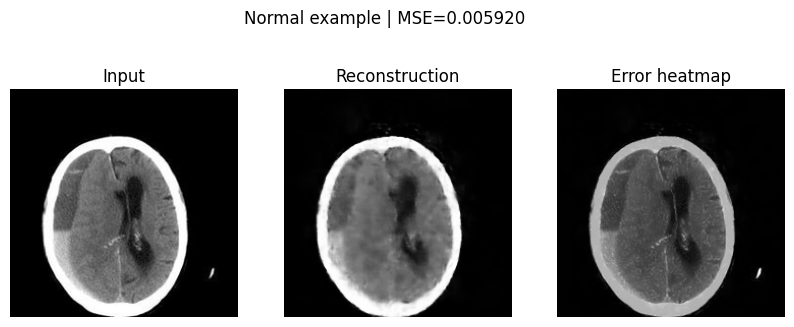

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


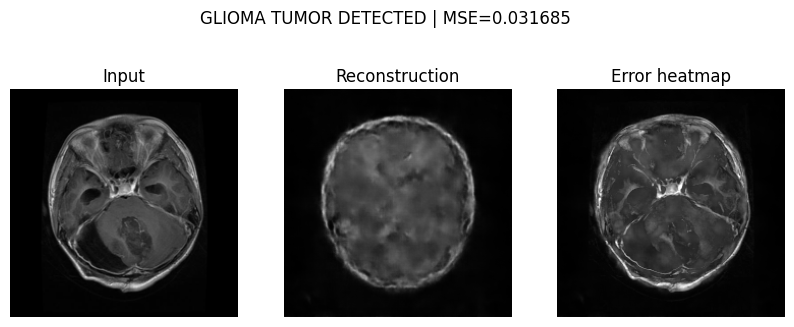

ROC-AUC=0.938  PR-AUC=0.940
Confusion matrix:
 [[364  41]
 [ 42 864]]
Report:
               precision    recall  f1-score   support

      normal       0.90      0.90      0.90       405
     anomaly       0.95      0.95      0.95       906

    accuracy                           0.94      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.94      0.94      0.94      1311



In [3]:
# ===== Anomaly scoring on 4-class test set (grayscale) + heatmaps =====
import os, torch, numpy as np, pandas as pd
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt

# ---- Reload same transforms, model, and checkpoint ----
IMG_SIZE = 224
tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=Image.BICUBIC),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

# Recreate model and load weights
C = 1
class ConvAE(nn.Module):
    def __init__(self, c=C, latent=256):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(c,   32, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(32,  64, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(64, 128, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(128,256, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(256,512, 3, 2, 1), nn.ReLU(True),
        )
        self.fc_mu  = nn.Linear(512*7*7, 256)
        self.fc_dec = nn.Linear(256, 512*7*7)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(512,256,4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(256,128,4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(128,64, 4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(32,  C, 4,2,1),
            nn.Tanh(),
        )
    def encode(self,x): return self.fc_mu(self.enc(x).view(x.size(0),-1))
    def decode(self,z): return self.dec(self.fc_dec(z).view(-1,512,7,7))
    def forward(self,x): return self.decode(self.encode(x))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAE().to(device)
model.load_state_dict(torch.load("checkpoints/ae_final_mse_gpu_gray.pt", map_location=device))
model.eval()

# ---- Test loader ----
TEST_DIR = os.path.join(DATA_ROOT, "test")
test_ds = datasets.ImageFolder(TEST_DIR, transform=tfms)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)
print("Test classes:", test_ds.classes)

def is_normal_class(name: str) -> bool:
    n = name.lower()
    return ("no" in n) and ("tumor" in n)

# ---- Score all test images ----
paths, y_true, scores = [], [], []
with torch.no_grad():
    for i, (xb, yb) in enumerate(test_dl):
        xb = xb.to(device, non_blocking=True)
        xh = model(xb)
        mse = F.mse_loss(xh, xb, reduction="mean").item()
        cls_name = test_ds.classes[yb.item()]
        y_true.append(0 if is_normal_class(cls_name) else 1)  # 0=normal, 1=anomaly
        scores.append(mse)
        paths.append(test_ds.samples[i][0])

df = pd.DataFrame({"path": paths, "true_is_anomaly": y_true, "score_mse": scores})

# ---- Threshold from NORMAL scores (95th percentile) ----
normal_scores = df[df.true_is_anomaly == 0]["score_mse"]
if len(normal_scores):
    thr = float(np.percentile(normal_scores, 90))
else:
    thr = float(np.percentile(df["score_mse"], 90))
df["pred_is_anomaly"] = (df["score_mse"] > thr).astype(int)

print(f"Chosen anomaly threshold: {thr:.6f}")
print(df.groupby("true_is_anomaly")["score_mse"].describe())
df.to_csv("anomaly_scores_gray.csv", index=False)
print("Saved -> anomaly_scores_gray.csv")

# ---- Heatmap utilities ----
def denorm(t):  # inverse of Normalize([0.5],[0.5])
    return (t*0.5 + 0.5).clamp(0,1)

def show_heatmap(xb, xh, title=""):
    err = (xh - xb).abs().mean(dim=1, keepdim=True)  # (B,1,H,W)
    err = (err - err.min()) / (err.max() - err.min() + 1e-8)
    x  = denorm(xb)
    xr = denorm(xh)

    x_np  = x[0].repeat(3,1,1).permute(1,2,0).detach().cpu().numpy()   # 1ch -> 3ch for display
    xr_np = xr[0].repeat(3,1,1).permute(1,2,0).detach().cpu().numpy()
    err_np = err[0].repeat(3,1,1).permute(1,2,0).detach().cpu().numpy()

    plt.figure(figsize=(10,4))
    plt.suptitle(f"{title} | MSE={F.mse_loss(xh, xb).item():.6f}")
    plt.subplot(1,3,1); plt.imshow(x_np);  plt.title("Input");          plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(xr_np); plt.title("Reconstruction"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(x_np*0.7 + err_np*0.6); plt.title("Error heatmap"); plt.axis("off")
    plt.show()

# ---- Show one normal & one tumour example ----
# normal
for xb, yb in test_dl:
    if is_normal_class(test_ds.classes[yb.item()]):
        xb = xb.to(device, non_blocking=True)
        with torch.no_grad():
            xh = model(xb)
        show_heatmap(xb, xh, "Normal example")
        break
# tumour
for xb, yb in test_dl:
    if not is_normal_class(test_ds.classes[yb.item()]):
        xb = xb.to(device, non_blocking=True)
        with torch.no_grad():
            xh = model(xb)
        show_heatmap(xb, xh, test_ds.classes[yb.item()])
        break

# ---- (Optional) Threshold-free metrics if sklearn available ----
try:
    from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix
    auc = roc_auc_score(df["true_is_anomaly"], df["score_mse"])
    ap  = average_precision_score(df["true_is_anomaly"], df["score_mse"])
    print(f"ROC-AUC={auc:.3f}  PR-AUC={ap:.3f}")
    print("Confusion matrix:\n", confusion_matrix(df["true_is_anomaly"], df["pred_is_anomaly"]))
    print("Report:\n", classification_report(df["true_is_anomaly"], df["pred_is_anomaly"], target_names=["normal","anomaly"]))
except Exception as e:
    print("sklearn metrics skipped:", e)


Device: cuda
Using threshold: 0.030000
Image: C:\Users\richu\OneDrive\Desktop\test\Tr-no_0027.jpg
MSE score: 0.004209
Prediction: NORMAL


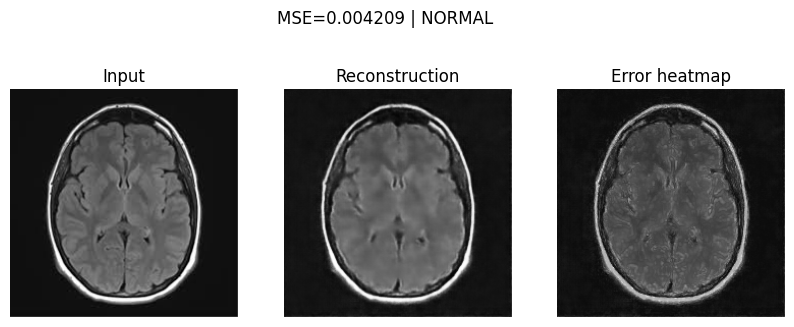

In [4]:
# ==== Single-image inference: MSE score + anomaly/normal + heatmap (grayscale) ====
import os, torch, numpy as np, matplotlib.pyplot as plt
import torch.nn as nn, torch.nn.functional as F
from PIL import Image
from torchvision import transforms

# ---------- CONFIG ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Path to ONE image you want to test
image_path = r"C:\Users\richu\OneDrive\Desktop\test\Tr-no_0027.jpg"  # <-- change

# Model checkpoint (from training)
ckpt_path = "checkpoints/ae_final_mse_gpu_gray.pt"

# If you previously ran the threshold-tuning cell, we try to load the tuned threshold from CSV.
# Otherwise, set a manual threshold here (e.g., 0.03) and it will use that.
manual_threshold = 0.03

# ---------- TRANSFORMS (must match training) ----------
IMG_SIZE = 224
tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=Image.BICUBIC),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

def denorm(t):  # inverse of Normalize([0.5],[0.5])
    return (t*0.5 + 0.5).clamp(0,1)

# ---------- MODEL (same as training) ----------
C = 1
class ConvAE(nn.Module):
    def __init__(self, c=C, latent=256):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(c,   32, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(32,  64, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(64,  128,3, 2, 1), nn.ReLU(True),
            nn.Conv2d(128, 256,3, 2, 1), nn.ReLU(True),
            nn.Conv2d(256, 512,3, 2, 1), nn.ReLU(True),
        )
        self.fc_mu  = nn.Linear(512*7*7, 256)
        self.fc_dec = nn.Linear(256, 512*7*7)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(512,256,4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(256,128,4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(128,64, 4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(32,  C, 4,2,1),
            nn.Tanh(),
        )
    def encode(self,x): return self.fc_mu(self.enc(x).view(x.size(0),-1))
    def decode(self,z): return self.dec(self.fc_dec(z).view(-1,512,7,7))
    def forward(self,x): return self.decode(self.encode(x))

# Load model
model = ConvAE().to(device)
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()

# ---------- Load threshold ----------
threshold = None
csv_tuned = "anomaly_scores_gray_tuned.csv"
if os.path.exists(csv_tuned):
    import pandas as pd
    df_thr = pd.read_csv(csv_tuned)
    if "threshold_used" in df_thr.columns and df_thr["threshold_used"].notna().any():
        # take the most frequent / last threshold used
        vals = df_thr["threshold_used"].dropna().values
        threshold = float(vals[-1])
if threshold is None:
    threshold = float(manual_threshold)
print(f"Using threshold: {threshold:.6f}")

# ---------- Inference on a single image ----------
assert os.path.exists(image_path), f"Image not found: {image_path}"
img_pil = Image.open(image_path).convert("L")  # grayscale
x = tfms(img_pil).unsqueeze(0).to(device)      # (1,1,H,W)

with torch.no_grad():
    xh = model(x)
    mse = F.mse_loss(xh, x, reduction="mean").item()

pred_is_anomaly = int(mse > threshold)
label_txt = "ANOMALY (likely tumour)" if pred_is_anomaly else "NORMAL"

print(f"Image: {image_path}")
print(f"MSE score: {mse:.6f}")
print(f"Prediction: {label_txt}")

# ---------- Heatmap visualization ----------
err = (xh - x).abs().mean(dim=1, keepdim=True)             # (1,1,H,W)
err = (err - err.min()) / (err.max() - err.min() + 1e-8)   # normalize for display
x_vis  = denorm(x)[0].repeat(3,1,1).permute(1,2,0).detach().cpu().numpy()
xr_vis = denorm(xh)[0].repeat(3,1,1).permute(1,2,0).detach().cpu().numpy()
e_vis  = err[0].repeat(3,1,1).permute(1,2,0).detach().cpu().numpy()

plt.figure(figsize=(10,4))
plt.suptitle(f"MSE={mse:.6f} | {label_txt}")
plt.subplot(1,3,1); plt.imshow(x_vis);              plt.title("Input");          plt.axis("off")
plt.subplot(1,3,2); plt.imshow(xr_vis);             plt.title("Reconstruction"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(x_vis*0.7 + e_vis*0.6); plt.title("Error heatmap");  plt.axis("off")
plt.show()


In [1]:
# --- Autoencoder (AE) training on "no tumor" images only ---
# Notebook-ready: no lambda in transforms, num_workers=0 for Windows/Jupyter.

import os, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image

# ====== CONFIG ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CHANGE THIS to your dataset root folder
DATA_ROOT = r"C:\Users\richu\OneDrive\Desktop\tumor testing"


TRAIN_DIR = os.path.join(DATA_ROOT, "training")

IMG_SIZE = 224
BATCH    = 32
EPOCHS   = 100
LR       = 1e-3

# Set to "L" if your images are grayscale (e.g., MRI slices). Keep "RGB" for color tiles.
convert_mode = "RGB"  # "L" for grayscale MRI; "RGB" otherwise

# ====== TRANSFORMS (no lambda; Jupyter/Windows-safe) ======
if convert_mode == "RGB":
    mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
    tfms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=Image.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
else:  # grayscale
    mean, std = [0.5], [0.5]
    tfms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=Image.BICUBIC),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

# ====== DATA ======
train_ds = datasets.ImageFolder(TRAIN_DIR, transform=tfms)

# num_workers=0 avoids PicklingError on Windows/Jupyter
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=0, pin_memory=False)

# ====== MODEL ======
C = 1 if convert_mode == "L" else 3

class ConvAE(nn.Module):
    def __init__(self, c=C, latent=256):
        super().__init__()
        # Encoder downsamples 224 -> 112 -> 56 -> 28 -> 14 -> 7
        self.enc = nn.Sequential(
            nn.Conv2d(c,   32, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(32,  64, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(64, 128, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(128,256, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(256,512, 3, 2, 1), nn.ReLU(True),
        )
        self.fc_mu  = nn.Linear(512*7*7, latent)
        self.fc_dec = nn.Linear(latent, 512*7*7)
        # Decoder upsamples 7 -> 14 -> 28 -> 56 -> 112 -> 224
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(512,256,4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(256,128,4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(128,64, 4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(32,  C, 4,2,1),
            nn.Tanh(),  # outputs in [-1,1] to match our normalization around 0
        )

    def encode(self, x):
        h = self.enc(x).view(x.size(0), -1)
        return self.fc_mu(h)

    def decode(self, z):
        h = self.fc_dec(z).view(-1, 512, 7, 7)
        return self.dec(h)

    def forward(self, x):
        return self.decode(self.encode(x))

model = ConvAE().to(device)
opt = torch.optim.Adam(model.parameters(), lr=LR)
crit = nn.MSELoss()

# ====== TRAIN ======
os.makedirs("checkpoints", exist_ok=True)
print(f"Device: {device}")
print(f"Training samples: {len(train_ds)} | Classes: {train_ds.classes}")

for ep in range(1, EPOCHS+1):
    model.train()
    running = 0.0
    for xb, _ in train_dl:
        xb = xb.to(device)
        xh = model(xb)
        loss = crit(xh, xb)
        opt.zero_grad()
        loss.backward()
        opt.step()
        running += loss.item() * xb.size(0)
    epoch_loss = running / len(train_dl.dataset)
    print(f"Epoch {ep:03d} | train_mse={epoch_loss:.6f}")

# Save final model
ckpt_path = "checkpoints/ae_final/ae_final_100epochs.pt"
os.makedirs(os.path.dirname(ckpt_path), exist_ok=True)  # create folder if missing
torch.save(model.state_dict(), ckpt_path)
print(f"Model saved → {ckpt_path}")

Device: cuda
Training samples: 1597 | Classes: ['NO TUMOR DETECTED']
Epoch 001 | train_mse=0.203819
Epoch 002 | train_mse=0.133502
Epoch 003 | train_mse=0.122275
Epoch 004 | train_mse=0.114743
Epoch 005 | train_mse=0.110220
Epoch 006 | train_mse=0.102722
Epoch 007 | train_mse=0.096185
Epoch 008 | train_mse=0.091325
Epoch 009 | train_mse=0.086222
Epoch 010 | train_mse=0.080745
Epoch 011 | train_mse=0.074665
Epoch 012 | train_mse=0.069796
Epoch 013 | train_mse=0.066249
Epoch 014 | train_mse=0.062525
Epoch 015 | train_mse=0.057907
Epoch 016 | train_mse=0.055499
Epoch 017 | train_mse=0.053223
Epoch 018 | train_mse=0.050359
Epoch 019 | train_mse=0.047100
Epoch 020 | train_mse=0.044381
Epoch 021 | train_mse=0.042604
Epoch 022 | train_mse=0.041328
Epoch 023 | train_mse=0.040481
Epoch 024 | train_mse=0.039258
Epoch 025 | train_mse=0.038671
Epoch 026 | train_mse=0.037300
Epoch 027 | train_mse=0.034719
Epoch 028 | train_mse=0.033941
Epoch 029 | train_mse=0.032415
Epoch 030 | train_mse=0.031544
E

## --- Autoencoder (AE) training on "no tumor" images only ---
# Notebook-ready: no lambda in transforms, num_workers=0 for Windows/Jupyter.

import os, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image

# ====== CONFIG ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CHANGE THIS to your dataset root folder
DATA_ROOT = r"C:\Users\richu\OneDrive\Desktop\tumor testing"

# The training dir must contain ONLY normal images in a class subfolder, e.g.:
# training/
#   no_tumor_detected/
#       *.png|*.jpg
TRAIN_DIR = os.path.join(DATA_ROOT, "training")

IMG_SIZE = 224
BATCH    = 32
EPOCHS   = 100
LR       = 1e-3

# Set to "L" if your images are grayscale (e.g., MRI slices). Keep "RGB" for color tiles.
convert_mode = "RGB"  # "L" for grayscale MRI; "RGB" otherwise

# ====== TRANSFORMS (no lambda; Jupyter/Windows-safe) ======
if convert_mode == "RGB":
    mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
    tfms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=Image.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
else:  # grayscale
    mean, std = [0.5], [0.5]
    tfms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=Image.BICUBIC),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

# ====== DATA ======
train_ds = datasets.ImageFolder(TRAIN_DIR, transform=tfms)

# num_workers=0 avoids PicklingError on Windows/Jupyter
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=0, pin_memory=False)

# ====== MODEL ======
C = 1 if convert_mode == "L" else 3

class ConvAE(nn.Module):
    def __init__(self, c=C, latent=256):
        super().__init__()
        # Encoder downsamples 224 -> 112 -> 56 -> 28 -> 14 -> 7
        self.enc = nn.Sequential(
            nn.Conv2d(c,   32, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(32,  64, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(64, 128, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(128,256, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(256,512, 3, 2, 1), nn.ReLU(True),
        )
        self.fc_mu  = nn.Linear(512*7*7, latent)
        self.fc_dec = nn.Linear(latent, 512*7*7)
        # Decoder upsamples 7 -> 14 -> 28 -> 56 -> 112 -> 224
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(512,256,4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(256,128,4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(128,64, 4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(32,  C, 4,2,1),
            nn.Tanh(),  # outputs in [-1,1] to match our normalization around 0
        )

    def encode(self, x):
        h = self.enc(x).view(x.size(0), -1)
        return self.fc_mu(h)

    def decode(self, z):
        h = self.fc_dec(z).view(-1, 512, 7, 7)
        return self.dec(h)

    def forward(self, x):
        return self.decode(self.encode(x))

model = ConvAE().to(device)
opt = torch.optim.Adam(model.parameters(), lr=LR)
crit = nn.MSELoss()

# ====== TRAIN ======
os.makedirs("checkpoints", exist_ok=True)
print(f"Device: {device}")
print(f"Training samples: {len(train_ds)} | Classes: {train_ds.classes}")

for ep in range(1, EPOCHS+1):
    model.train()
    running = 0.0
    for xb, _ in train_dl:
        xb = xb.to(device)
        xh = model(xb)
        loss = crit(xh, xb)
        opt.zero_grad()
        loss.backward()
        opt.step()
        running += loss.item() * xb.size(0)
    epoch_loss = running / len(train_dl.dataset)
    print(f"Epoch {ep:03d} | train_mse={epoch_loss:.6f}")

# Save final model
ckpt_path = "checkpoints/ae_finalhundredepochs.pt"
torch.save(model.state_dict(), ckpt_path)
print(f"Model saved → {ckpt_path}")


In [7]:
import torch, torchvision
print(torch.__version__, torchvision.__version__)


NameError: name '_C' is not defined

In [6]:
import os

DATA_ROOT = r"C:\Users\richu\OneDrive\Desktop\tumor testing"
print(os.listdir(DATA_ROOT))


['Testing', 'training']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


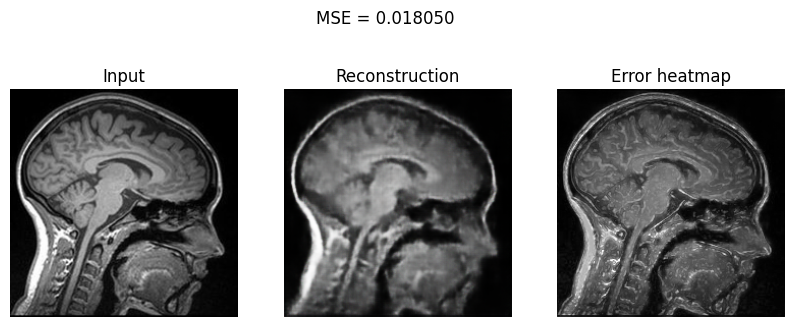

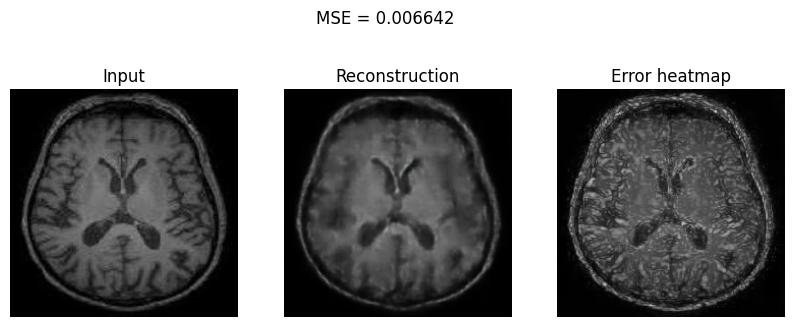

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


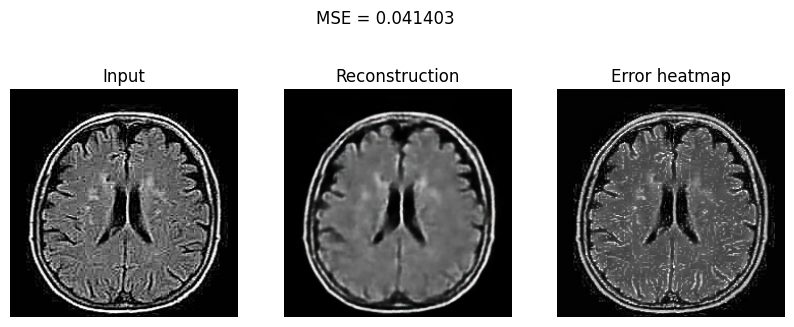

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


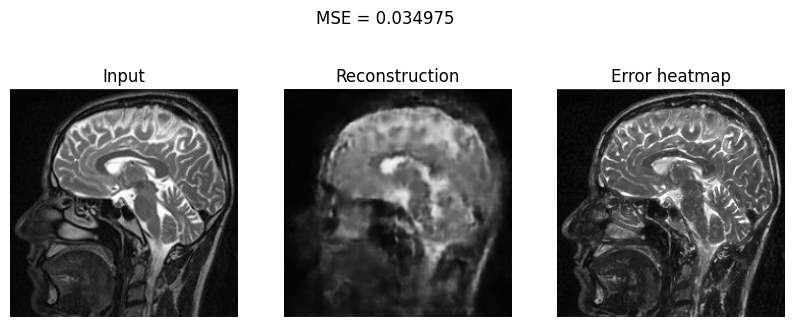

ConvAE(
  (enc): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): ReLU(inplace=True)
  )
  (fc_mu): Linear(in_features=25088, out_features=256, bias=True)
  (fc_dec): Linear(in_features=256, out_features=25088, bias=True)
  (dec): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2

In [7]:
# --- Preview input vs reconstruction (+ error heatmap) ---

import torch
import matplotlib.pyplot as plt

# Put model in eval mode
model.eval()

# Get one small batch from the training loader
xb, _ = next(iter(train_dl))
xb = xb.to(device)

with torch.no_grad():
    xh = model(xb)

# Compute per-image MSE (just for info)
mse_per_img = ((xh - xb) ** 2).view(xb.size(0), -1).mean(dim=1).detach().cpu().numpy()

def denorm(t):
    """Denormalize from [-1,1] (since you used mean=0.5, std=0.5 and Tanh output)."""
    t = (t * 0.5 + 0.5).clamp(0, 1)
    return t

def show_example(idx=0):
    """Show input, reconstruction, and error heatmap for one image index in the batch."""
    x  = denorm(xb[idx:idx+1]).squeeze(0).detach().cpu()
    xr = denorm(xh[idx:idx+1]).squeeze(0).detach().cpu()

    # error map (channel-avg absolute error), normalized to [0,1] for display
    err = (xr - x).abs().mean(dim=0, keepdim=True)  # (1,H,W)
    err = (err - err.min()) / (err.max() - err.min() + 1e-8)
    # make 3-channel for overlay (works for grayscale or RGB)
    if x.ndim == 3 and x.shape[0] == 1:
        x_vis  = x.repeat(3,1,1).permute(1,2,0).numpy()
        err_vis = err.repeat(3,1,1).permute(1,2,0).numpy()
        xr_vis = xr.repeat(3,1,1).permute(1,2,0).numpy()
    else:
        x_vis  = x.permute(1,2,0).numpy()
        err_vis = err.repeat(3,1,1).permute(1,2,0).numpy()
        xr_vis = xr.permute(1,2,0).numpy()

    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1); plt.imshow(x_vis);  plt.title("Input");          plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(xr_vis); plt.title("Reconstruction");  plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(x_vis*0.7 + err_vis*0.6); plt.title("Error heatmap"); plt.axis("off")
    plt.suptitle(f"MSE = {mse_per_img[idx]:.6f}")
    plt.show()

# Show a few samples (change indexes if you like)
for i in range(min(4, xb.size(0))):
    show_example(i)

# Back to train mode if you want to continue training later
model.train()


In [1]:
import torch, torchvision
print(torch.__version__, torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


2.3.1+cu121 0.18.1+cu121
CUDA available: True
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
